# **High-Dimensional Diffusion MRI Reconstruction Tutorial**

### Introduction:

  * High-dimensional MRI (HD-MRI) refers to the acquisition of more than 2D imaging data;
  * Typical examples are dynamic MRI, quantitative parameter mapping, and **diffusion MRI**.


  * This notebook 

    1. extends the linear operator abstraction framework in [SigPy](https://github.com/mikgroup/sigpy) to achieve HD-MRI reconstruction;
    2. utilizes data acquired from an advanced high-resolution multi-shot diffusion MRI pulse sequence at 7 T;
    3. demonstrates a comprehensive forward modeling comprising **shot-to-shot phase variation**;
    3. constrcuts HD regularization terms, e.g. overlapping locally low rank (LLR), for HD-MRI reconstruction.

### Authors:

  * Zhengguo Tan <zhengguo.tan@fau.de> or <zhengguo.tan@gmail.com>
  * Patrick A Liebig <patrick.liebig@siemens-healthineers.com>
  * Robin M Heidemann <robin.heidemann@siemens-healthineers.com>
  * Fredrik B Laun <Frederik.Laun@uk-erlangen.de>
  * Florian Knoll <florian.knoll@fau.de>


### Notes:

  * This demo presents an improved version of our ISMRM 2023 abstract 3961.

# 1. Setup

## Connect to a GPU on `Google Colab`

  * Go to `Edit` > `Notebook settings` > select `GPU` > click `Save`;
  * Now we can verify that we allocate a GPU for this notebook.

In [1]:
!nvidia-smi
!nvcc --version

/bin/bash: nvidia-smi: command not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


## Install SigPy

  * The original [SigPy](https://github.com/mikgroup/sigpy.git) was forked for the development of HD-MRI reconstruction and is available here: https://github.com/ZhengguoTan/sigpy.git

In [2]:
!git clone https://github.com/ZhengguoTan/sigpy.git

Cloning into 'sigpy'...
remote: Enumerating objects: 6368, done.
remote: Counting objects: 100% (904/904), done.
remote: Compressing objects: 100% (330/330), done.
remote: Total 6368 (delta 617), reused 793 (delta 560), pack-reused 5464
Receiving objects: 100% (6368/6368), 3.81 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (4637/4637), done.


In [3]:
%cd /content/sigpy
!git log -1

/content/sigpy
commit 6250f356ba0e254b5c18379b00965cca6d9b3123 (HEAD -> master, origin/master, origin/HEAD)
Author: Zhengguo Tan <zhengguo.tan@gmail.com>
Date:   Tue May 30 22:38:43 2023 +0200

    numpy version


In [4]:
!pip install -e /content/sigpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/sigpy
  Preparing metadata (setup.py) ... done
  Running setup.py develop for sigpy


# 2. Build a Shot-Phase-Informed Parallel Imaging Reconstruction

(1) Read in data

Data  | Diffusion encodings | Shots | Coils | Slices | Phase encoding | Readout 
--    | --                  | --    | --    | --     | --             | -- 
imaging echo | 4  | 5 | 32 | 1 | 440 | 440 
shot phase | 4  | 5 | 32 | 2 | 440 | 440
coil sensitivity maps | - | - | 32 | 2 | 440 | 440


In [5]:
# ALTERNATIVE FOR INTERACTIVE PRESENTATION TO SAVE TIME

# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR='/content/drive/MyDrive/Colab Notebooks/2023_ISMRM_MR-Pub-III/data/'

Mounted at /content/drive


In [5]:
%%bash

mkdir /content/data && cd "$_"
pwd

RECORD='7989635'

wget -q https://zenodo.org/record/${RECORD}/files/0.5x0.5x2.0mm_coil.h5
wget -q https://zenodo.org/record/${RECORD}/files/0.5x0.5x2.0mm_kdat_slice_000.h5
wget -q https://zenodo.org/record/${RECORD}/files/0.5x0.5x2.0mm_phase.h5
wget -q https://zenodo.org/record/${RECORD}/files/md5sum.txt

cd /content/sigpy

/content/data


In [6]:
DATA_DIR='/content/data/'

In [6]:
import h5py
import numpy as np

import sigpy as sp
from sigpy.mri import app, retro, sms


# imaging echo (kdat)
f = h5py.File(DATA_DIR + '0.5x0.5x2.0mm_kdat_slice_000.h5', 'r')
kdat = f['kdat'][:]
MB = f['MB'][()]
N_slices = f['Slices'][()]
N_segments = f['Segments'][()]
N_Accel_PE = f['Accel_PE'][()]
f.close()

kdat = np.squeeze(kdat)  # 4 dim
kdat = np.swapaxes(kdat, -2, -3)

# # split kdat into shots
N_diff = kdat.shape[-4]
kdat_prep = []
for d in range(N_diff):
    k = retro.split_shots(kdat[d, ...], shots=N_segments)
    kdat_prep.append(k)

kdat_prep = np.array(kdat_prep)
kdat_prep = kdat_prep[..., None, :, :]  # 6 dim

print(' > kdat shape: ', kdat_prep.shape)


# coil
f = h5py.File(DATA_DIR + '0.5x0.5x2.0mm_coil.h5', 'r')
coil = f['coil'][:]
f.close()

print(' > coil shape: ', coil.shape)

N_coil, N_z, N_y, N_x = coil.shape


# shot phase
f = h5py.File(DATA_DIR + '0.5x0.5x2.0mm_phase.h5', 'r')
shot_phase = f['phase'][:]
f.close()

print(' > shot phase shape: ', shot_phase.shape)


# SMS phase shift
yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB, yshift=yshift)

 > kdat shape:  (4, 5, 32, 1, 440, 440)
 > coil shape:  (32, 2, 440, 440)
 > shot phase shape:  (4, 5, 1, 2, 440, 440)
 > sms: yshift  [0.0, 0.3333333333333333]


Reduce data size for GPU T4

In [7]:
# ================================================ #
# ATTENTION: 
#  Data is too large for GPU T4 on Google Colab
# ================================================ #
redu = 0.5  # change this to 1 if you have better GPU
small_fov = [int(N_y * redu), int(N_x * redu)]

print(' > reduced FOV: ', small_fov)

kdat_prep_redu = sp.resize(kdat_prep, oshape=list(kdat_prep.shape[:-2]) +\
                           small_fov)

import torchvision.transforms as T
TR = T.Resize(small_fov, antialias=True)

coil_tensor = sp.to_pytorch(coil)
coil_tensor_r = TR(coil_tensor[..., 0]).cpu().detach().numpy()
coil_tensor_i = TR(coil_tensor[..., 1]).cpu().detach().numpy()
coil_redu = coil_tensor_r + 1j * coil_tensor_i
print(' > coil_redu shape: ', coil_redu.shape)

shot_phase_tensor = sp.to_pytorch(shot_phase.reshape([-1, N_y, N_x]))
shot_phase_tensor_r = TR(shot_phase_tensor[..., 0]).cpu().detach().numpy()
shot_phase_tensor_i = TR(shot_phase_tensor[..., 1]).cpu().detach().numpy()
shot_phase_redu = shot_phase_tensor_r + 1j * shot_phase_tensor_i
shot_phase_redu = shot_phase_redu.reshape(list(shot_phase.shape[:-2]) + small_fov)
print(' > shot_phase_redu shape: ', shot_phase_redu.shape)

sms_phase_redu = sms.get_sms_phase_shift([MB] + small_fov, MB=MB, yshift=yshift)

 > reduced FOV:  [220, 220]
 > coil_redu shape:  (32, 2, 220, 220)
 > shot_phase_redu shape:  (4, 5, 1, 2, 220, 220)
 > sms: yshift  [0.0, 0.3333333333333333]


Plot sampling pattern

(4, 5, 32, 1, 220, 220)
(50, 5, 4)


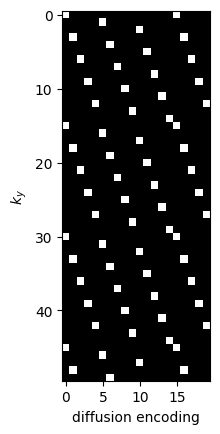

In [9]:
import matplotlib.pyplot as plt

print(kdat_prep_redu.shape)

ylen = 50

kl = kdat_prep_redu[:, :, 0, 0, 34:34+ylen, 10].T
print(kl.shape)

ind = kl != 0

kl1 = np.zeros_like(kl)
kl1[ind] = 1


kl2 = np.zeros_like(kl, shape=[ylen, np.prod(kl.shape[1:])])

for n in range(N_diff):
  kl2[:, 5*n:5*(n+1)] = kl1[..., n]

fig, ax = plt.subplots(1, 1)

ax.imshow(abs(kl2), cmap='gray',
           interpolation='None')
ax.set_xticks(range(0, 20, 5))
ax.set_aspect('equal', 'box')
ax.set_xlabel('diffusion encoding')
ax.set_ylabel('$k_y$')
plt.show()

In [9]:
# copy data to GPU
import torch

if torch.cuda.is_available():
  kdat_prep_redu = sp.to_device(kdat_prep_redu, device=sp.Device(0))
  coil_redu = sp.to_device(coil_redu, device=sp.Device(0))
  shot_phase_redu = sp.to_device(shot_phase_redu, device=sp.Device(0))
  sms_phase_redu = sp.to_device(sms_phase_redu, device=sp.Device(0))

In [10]:
img_shape = [1] + list(coil_redu.shape[1:])

DWI_PI = []

for n in range(N_diff):

  print('> Diffusion Encoding #', n)

  # # construct forward model

  device = sp.get_device(kdat_prep_redu)
  xp = device.xp

  shot_phase_n = shot_phase_redu[n, ...]
  kdat_prep_n = kdat_prep_redu[n, ...]

  # 1. shot phase
  P = sp.linop.Multiply(img_shape, xp.conj(shot_phase_n))
  # 2. coils
  S = sp.linop.Multiply(P.oshape, coil_redu)
  # 3. FFT
  F = sp.linop.FFT(S.oshape, axes=[-2, -1])
  # 4. SMS
  PHI = sp.linop.Multiply(F.oshape, sms_phase_redu)
  SUM = sp.linop.Sum(PHI.oshape, axes=(-3,), keepdims=True)
  M = SUM * PHI
  # 5. sampling mask
  weights = app._estimate_weights(kdat_prep_n, None, None, coil_dim=-4)
  W = sp.linop.Multiply(M.oshape, weights**0.5)

  # chain
  A = W * M * F * S * P

  print('  MR Forward Operator Input Shape: ', A.ishape)
  print('  MR Forward Operator Output Shape: ', A.oshape)

  # # Linear Least Square Solve

  AHA = lambda x: A.N(x) + 0.01 * x
  AHy = A.H(kdat_prep_n)

  img = xp.zeros(A.ishape, dtype=kdat_prep_n.dtype)
  alg_method = sp.alg.ConjugateGradient(AHA, AHy, img,
                          tol=0,
                          max_iter=30, verbose=True)

  while (not alg_method.done()):
    alg_method.update()

  DWI_PI.append(sp.to_device(img)) # to CPU


DWI_PI = np.array(DWI_PI)
print(DWI_PI.shape)

> Diffusion Encoding # 0
  MR Forward Operator Input Shape:  [1, 2, 220, 220]
  MR Forward Operator Output Shape:  [5, 32, 1, 220, 220]
  cg iter:  0; resid:      0.005078
  cg iter:  1; resid:      0.002335
  cg iter:  2; resid:      0.001079
  cg iter:  3; resid:      0.000541
  cg iter:  4; resid:      0.000298
  cg iter:  5; resid:      0.000211
  cg iter:  6; resid:      0.000158
  cg iter:  7; resid:      0.000120
  cg iter:  8; resid:      0.000093
  cg iter:  9; resid:      0.000068
  cg iter: 10; resid:      0.000056
  cg iter: 11; resid:      0.000045
  cg iter: 12; resid:      0.000036
  cg iter: 13; resid:      0.000030
  cg iter: 14; resid:      0.000025
  cg iter: 15; resid:      0.000020
  cg iter: 16; resid:      0.000017
  cg iter: 17; resid:      0.000014
  cg iter: 18; resid:      0.000011
  cg iter: 19; resid:      0.000009
  cg iter: 20; resid:      0.000007
  cg iter: 21; resid:      0.000006
  cg iter: 22; resid:      0.000005
  cg iter: 23; resid:      0.000004


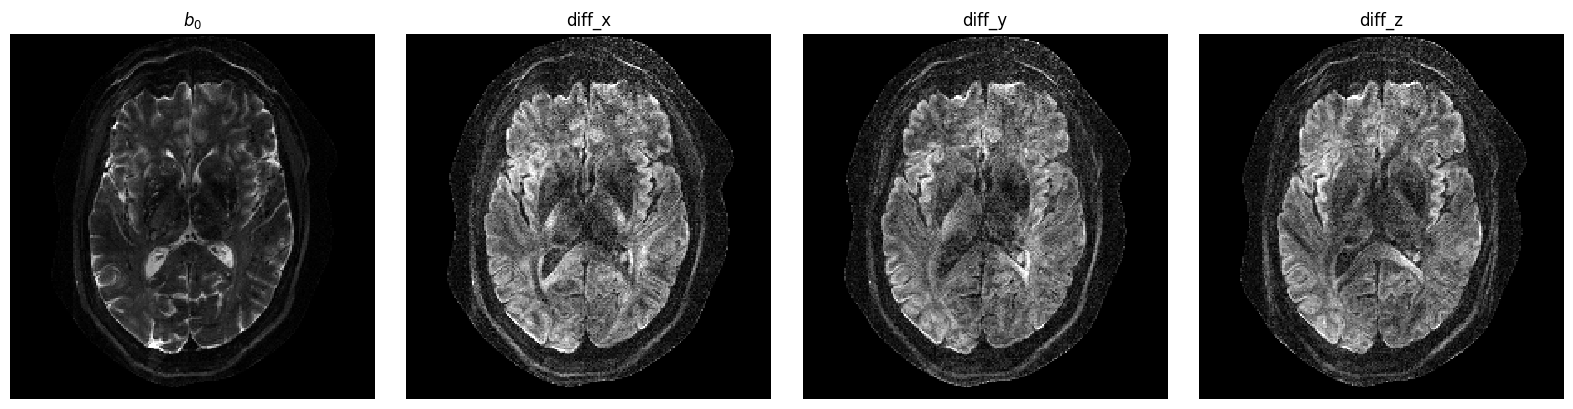

In [11]:
import matplotlib.pyplot as plt

DWI_PI_i = np.flip(np.squeeze(DWI_PI), axis=[-2, -1])

disp_str = ['$b_0$', 'diff_x', 'diff_y', 'diff_z']

fig, ax = plt.subplots(1, 4, figsize=(16,4))
for n in range(N_diff):
  img = abs(DWI_PI_i[n, 1, :, :])
  ax[n].imshow(img, cmap='gray', vmin=0, vmax=np.amax(img) * 0.6,
               interpolation='None')
  ax[n].set_axis_off()
  ax[n].set_title(disp_str[n])

plt.tight_layout()

# 4. LLR Regularization

The core concept of LLR is to enforce low rankness in local patches.

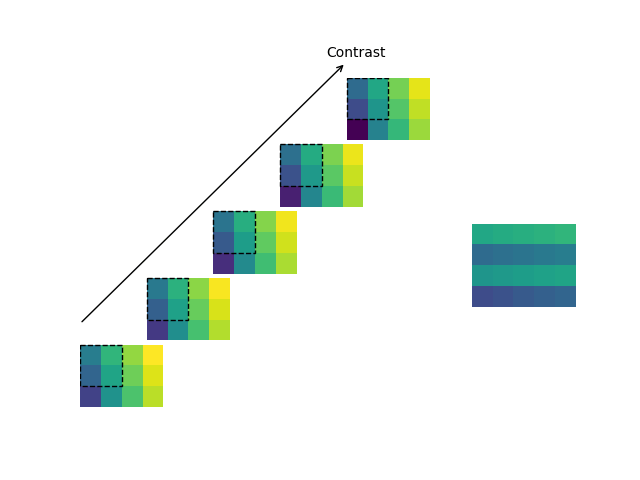

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import imageio.v2 as imageio

blocks = [2, 2]
strides = [1, 1]

sepa = 3.2

nrows = 3
ncols = 4
nvars = 5
Z = np.arange(nrows * ncols * nvars).reshape(ncols, nrows, nvars) ** 0.6
Z = Z.transpose()
x = np.arange(ncols + 1)
y = np.arange(nrows + 1)


len_x = (ncols - blocks[-1] + strides[-1]) // strides[-1]
len_y = (ncols - blocks[-2] + strides[-2]) // strides[-2]

fig_cnt = 0
frames = []

for ind_y in range(len_y, 1, -1):
  for ind_x in range(0, len_x, 1):

    fig, ax = plt.subplots()

    # plot arrays
    for ind in range(nvars):
      Z1 = Z[ind, ...]
      ax.pcolormesh(x-sepa*ind, y-sepa*ind, Z1, shading='flat', 
                    vmin=Z.min(), vmax=Z.max())
    
    # draw arrow
    offset = 4
    ax.annotate('Contrast', 
                xytext=(x[0] - 1, y[0] + offset),
                xy=(x[0] - sepa*(nvars-1), y[0] - sepa*(nvars-1) + offset),
                arrowprops=(dict(arrowstyle='<-')))

    # plot blocks
    for ind_z in range(nvars):

      rect = Rectangle((ind_x - sepa*ind_z, ind_y-sepa*ind_z), 
                       blocks[-1], -blocks[-2],
                       facecolor='none', edgecolor='k', linestyle='--')
      ax.add_patch(rect)

    # plot flattened blocks
    Z2 = Z[:, ind_y-blocks[-2] : ind_y, ind_x : ind_x+blocks[-1]]
    Z2 = np.reshape(Z2, [nvars, -1]).transpose()

    Z2_shape = Z2.shape

    ax.pcolormesh(np.arange(Z2_shape[-1]+1)+6, np.arange(Z2_shape[-2]+1)-8, Z2, 
                  shading='flat', vmin=Z.min(), vmax=Z.max())

    ax.set_aspect('equal')
    ax.set_axis_off()

    fig_name = f'/content/frame_{fig_cnt}.png'
    plt.savefig(fig_name)

    fig_cnt = fig_cnt + 1

    plt.close()
    
    # Append the current image to the list of frames
    frames.append(imageio.imread(fig_name))


# Save the frames as a GIF
output_file = '/content/llr_animation.gif'
# Adjust the duration between frames as needed
imageio.mimsave(output_file, frames, duration=1)

# display gif
from IPython.display import Image
Image(open(output_file, 'rb').read())

Overlapping blocks lead to duplicate values in the adjoint operator.

In [ ]:
import numpy as np
import sigpy as sp
from sigpy import linop

x = np.arange(60).reshape([5, 3, 4])

T = linop.ArrayToBlocks(x.shape, blk_shape=(2, 2), blk_strides=(1, 1), 
                        mean=False)

blocks = T * x

y = T.H * T * x

print('>>>>> \n3D array: ')
print(x)

print('>>>>> \nblocks shape: ')
print(blocks.shape)

print('>>>>> \ny: ')
print(y)

>>>>> 
3D array: 
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]

 [[24 25 26 27]
  [28 29 30 31]
  [32 33 34 35]]

 [[36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]

 [[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]]]
>>>>> 
blocks shape: 
(5, 2, 3, 2, 2)
>>>>> 
y: 
[[[  0.   2.   4.   3.]
  [  8.  20.  24.  14.]
  [  8.  18.  20.  11.]]

 [[ 12.  26.  28.  15.]
  [ 32.  68.  72.  38.]
  [ 20.  42.  44.  23.]]

 [[ 24.  50.  52.  27.]
  [ 56. 116. 120.  62.]
  [ 32.  66.  68.  35.]]

 [[ 36.  74.  76.  39.]
  [ 80. 164. 168.  86.]
  [ 44.  90.  92.  47.]]

 [[ 48.  98. 100.  51.]
  [104. 212. 216. 110.]
  [ 56. 114. 116.  59.]]]


We can fix this problem using a scaling matrix

In [ ]:
# now we compute the scaling matrix to correct the overlapping problem
I = np.ones_like(x)
S = T.H * T * I

# now we can apply this caling matrix to correct for y
y_corr = (T.H * T * x) / S

print('>>>>> \n3D array: ')
print(x)

print('>>>>> \ny_corr: ')
print(y_corr)

>>>>> 
3D array: 
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]

 [[24 25 26 27]
  [28 29 30 31]
  [32 33 34 35]]

 [[36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]

 [[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]]]
>>>>> 
y_corr: 
[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]
  [ 8.  9. 10. 11.]]

 [[12. 13. 14. 15.]
  [16. 17. 18. 19.]
  [20. 21. 22. 23.]]

 [[24. 25. 26. 27.]
  [28. 29. 30. 31.]
  [32. 33. 34. 35.]]

 [[36. 37. 38. 39.]
  [40. 41. 42. 43.]
  [44. 45. 46. 47.]]

 [[48. 49. 50. 51.]
  [52. 53. 54. 55.]
  [56. 57. 58. 59.]]]


# 5. Diffusion MRI Reconstruction with Spatial-Diffusion LLR Regularization

In [ ]:
from sigpy.mri import app

DWI_JETS = app.HighDimensionalRecon(kdat_prep_redu, 
                                    coil_redu,
                                    phase_sms=sms_phase_redu,
                                    combine_echo=True,
                                    phase_echo=np.conj(shot_phase_redu),
                                    regu='LLR',
                                    blk_shape=(1, 3, 3),
                                    blk_strides=(1, 1, 1),
                                    solver='ADMM',
                                    lamda=0.08,
                                    rho=0.05,
                                    max_iter=15,
                                    show_pbar=False, verbose=True,
                                    device=sp.Device(0)).run()

DWI_JETS = sp.to_device(DWI_JETS)

  cg iter:  0; resid:      7.870841
  cg iter:  1; resid:      3.644258
  cg iter:  2; resid:      1.606816
  cg iter:  3; resid:      0.818206
  cg iter:  4; resid:      0.449709
  cg iter:  5; resid:      0.294385
  cg iter:  6; resid:      0.189591
  cg iter:  7; resid:      0.118447
  cg iter:  8; resid:      0.074891
  cg iter:  9; resid:      0.074891
admm iter:  1, r norm:    57.0847, eps pri:     0.1246, s norm:     0.5863, eps dual:     0.0622
  cg iter:  0; resid:      1.061458
  cg iter:  1; resid:      0.564326
  cg iter:  2; resid:      0.331394
  cg iter:  3; resid:      0.216668
  cg iter:  4; resid:      0.141812
  cg iter:  5; resid:      0.088237
  cg iter:  6; resid:      0.053829
  cg iter:  7; resid:      0.035719
  cg iter:  8; resid:      0.023478
  cg iter:  9; resid:      0.023478
admm iter:  2, r norm:    28.7832, eps pri:     0.1169, s norm:     1.6554, eps dual:     0.0651
  cg iter:  0; resid:      0.748410
  cg iter:  1; resid:      0.407313
  cg iter:  2;

(4, 1, 1, 2, 220, 220)


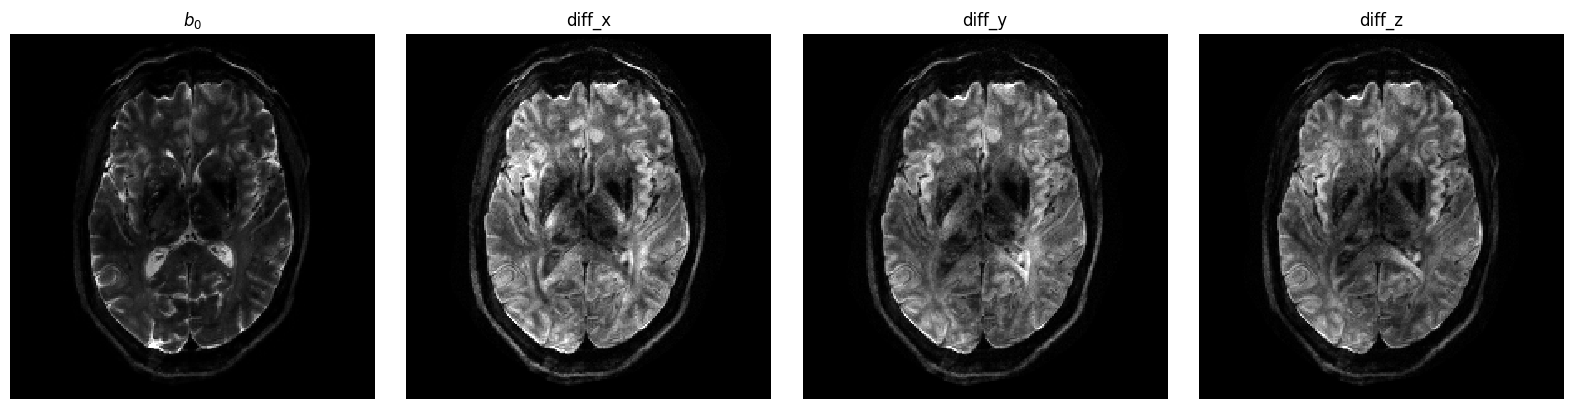

In [ ]:
import matplotlib.pyplot as plt

print(DWI_JETS.shape)

DWI_JETS_i = np.flip(np.squeeze(DWI_JETS), axis=[-2, -1])

disp_str = ['$b_0$', 'diff_x', 'diff_y', 'diff_z']

fig, ax = plt.subplots(1, 4, figsize=(16,4))
for n in range(N_diff):
  img = abs(np.squeeze(DWI_JETS_i[n, 1, :, :]))
  ax[n].imshow(img, cmap='gray', vmin=0, vmax=np.amax(img) * 0.6,
               interpolation='None')
  ax[n].set_axis_off()
  ax[n].set_title(disp_str[n])

plt.tight_layout()

# 6. Compute **TRACE** Image

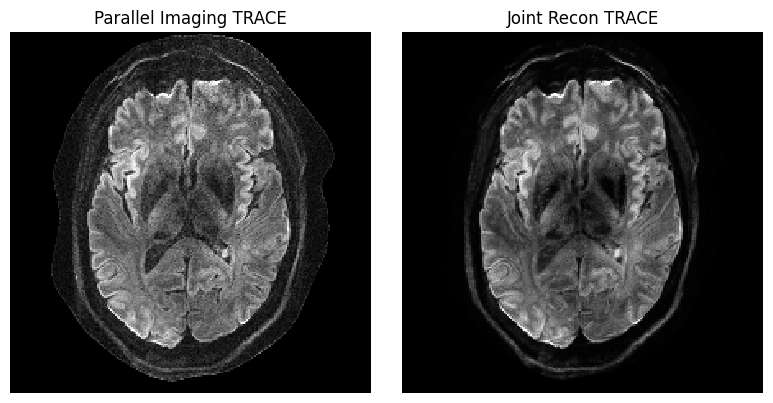

In [ ]:
from scipy.stats import gmean

DWI_PI_i = np.flip(np.squeeze(DWI_PI), axis=[-2, -1])
dif_PI = DWI_PI_i[1:, 1, :, :]

DWI_JETS_i = np.flip(np.squeeze(DWI_JETS), axis=[-2, -1])
dif_JETS = DWI_JETS_i[1:, 1, :, :]

trace_PI = gmean(abs(dif_PI))
trace_JETS = gmean(abs(dif_JETS))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(trace_PI, cmap='gray',
             vmin=0, vmax=np.amax(trace_PI) * 0.6,
             interpolation='None')
ax[0].set_title('Parallel Imaging TRACE')


ax[1].imshow(trace_JETS, cmap='gray',
             vmin=0, vmax=np.amax(trace_JETS) * 0.6,
             interpolation='None')
ax[1].set_title('Joint Recon TRACE')

for n in range(2):
  ax[n].set_axis_off()

plt.tight_layout()

# **Thank You for Your Attention!**